In [123]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import datetime

In [53]:
%%HTML
<h3> Loading Data Set </h3>

In [54]:

data_path = './data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [55]:
type(cifar10)

torchvision.datasets.cifar.CIFAR10

In [56]:
len(cifar10)

50000

In [57]:
img, label = cifar10[99]
img, label

(<PIL.Image.Image image mode=RGB size=32x32 at 0x11637B93610>, 1)

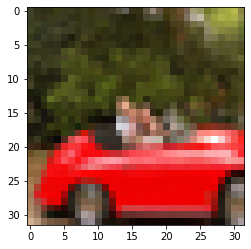

In [58]:
plt.imshow(img)
plt.show()

In [59]:
%%HTML
<h3> DataSet Transformation </h3>

In [60]:
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'transforms']

In [61]:
#We can use ToTensor to turn a PIL image into a tensor in CxHxW chaneel, height,width format
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [62]:
#now TOTensor on cifar10 data set
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,transform = transforms.ToTensor())

In [63]:
#Now when you access the data set it will return a tensor instead of a PIL image
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [64]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [65]:
#The orginal PIL image range was reduced from 0 to 255 to 0 to 1
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

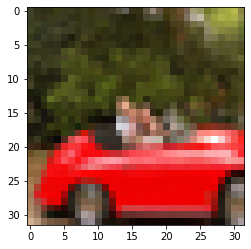

In [66]:
#verify image output.
#use Permute to change order of the channels
#matplotlib expects HxWxC
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [67]:
%%HTML
<h3> Normalize Data </h3>

In [68]:
#Chain transfomrs together by using tramsforms.Compose
#Normalize the dataset so that each channel has a mean of zero and standard dev of 1
#this is done because of our activation functions. They tend to range from 0 to 1 and normalizing
#the data will allow more neurons to fire and thus induce learning
#use transforms.Normalize




In [69]:
#Stack all images in a 4th dimension
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim = 3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [70]:
#find mean in each channel

mean_tensor = imgs.view(3, -1).mean(dim=1)
mean_tensor

tensor([0.4915, 0.4823, 0.4468])

In [71]:
#find std def 

std_tensor = imgs.view(3,-1).std(dim=1)
std_tensor

tensor([0.2470, 0.2435, 0.2616])

In [72]:
#Now normalize 
transforms.Normalize(mean_tensor, std_tensor)

Normalize(mean=tensor([0.4915, 0.4823, 0.4468]), std=tensor([0.2470, 0.2435, 0.2616]))

In [73]:
#This transforms.Normalize above should be concatenated to the datasets.CIFAR10 call
#chain the transforms.ToTensor() and the transforms.Normalize() togther with transforms.Compose
transformed_cifar10 = datasets.CIFAR10(data_path, train = True, download = False, transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean_tensor, std_tensor)]))

In [74]:
#Same for validation
transformed_cifar10_val = datasets.CIFAR10(data_path, train= True, download = False, transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean_tensor, std_tensor)]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


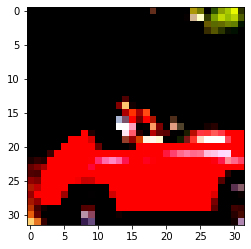

In [75]:
#image after normalization
img_t, _ =transformed_cifar10[99]

plt.imshow(img_t.permute(1,2,0))
plt.show()

In [76]:
%%HTML
<h3> Build A Neural Network That Can Distiguish Between Birds and Airplanes </h3>

In [77]:
#Build your dataset of birds and airplanes
label_map = {0:0, 2:1}
class_names= ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]


In [78]:
#Make your nueral network model
#Here we will take a linear layer that will take the the image vectors as flattened vectors
#the (3x32x32) CxHxW vector will be multiplied out to get 3072 input features in a linear vector
#the linear layer will taper things to 512 features. This number is chosen out of random
#We will use tanh activation funtion 
#last layer will be a linear layer that tapers the network down to our appropriate number of output features
#here we want 2 output features. We are classifying two things 0 for airplane and 1 for bird
#This is a categorical output and we will want to represent it as a onehot encode
#airplane will come in as (1,0), and birds (0,1). The airplane is first entry, bird is secnod
#Those values are ideal and we will likely see a probability value for each entry
#To do this we will use Softmax. Softmax turns numbers into probabilities
#The Softmax will take the output of the last linear layer of a multiclass nn and turns it into probailities 
#All the probabilities in softmax output must equal zero
#https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d
#Use nn.Sequential to stack your layers
n_out = 2

model = nn.Sequential(
    nn.Linear(3072, 512,),
    nn.Tanh(),
    nn.Linear(512, n_out,))

In [79]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [80]:
#Test on input vector
x = torch.tensor([1.0,2.0,3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [81]:
#the sum of the softmax probs must equal 1
assert softmax(x).sum() ==1

In [82]:
#must specify dim with nnSoftmax

softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [83]:
#now add sofmax to end of model
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512,2),
    nn.Softmax(dim =1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


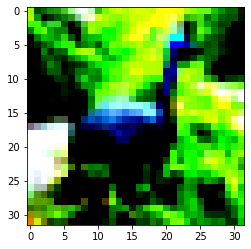

In [84]:
#Try out model before we train it?
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()


In [85]:
#make input of img into correct dimentions of 3072 features and add another dimention on 0th dim
img_batch = img.view(-1).unsqueeze(0)

In [86]:
out = model(img_batch)
out

tensor([[0.4472, 0.5528]], grad_fn=<SoftmaxBackward>)

In [87]:
#We can see that on the untrained model we get a nice prediction for this one test image

In [88]:
_, index = torch.max(out, dim=1)
index

tensor([1])

In [89]:
#Here we will use the MSE loss
#We want to penalize misclassifications
#We want a loss function that is very high when the likelihood is low, and loss that is low when the likelihood is high
#the negative log likelihood loss function is what we need 
#We can use Pytorch nn.NLLLoss
#rember that NLL takes probabilities

In [90]:
#Again here is the plan:
#1 for each sample run forward prop and get output values from last linear layer (2 features)
#2 find the Softmax and obtain propabilities. Note here we will us nn.LogSoftmax
#3 take the probability of the correct class (likelihood) and compute negative log and add to the losss
#Note: this is supervised learning so we know what the correct class is, it's the ground truth

In [91]:
#update model
model = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1))

In [92]:
#Init Loss
#Remember the loss is taking the output of the nn.LogSoftmax - our log probabilites
loss = nn.NLLLoss()

In [93]:
#Now test

img, label = cifar2[0]
#remember that the view method is equivalent to reshape
#view(-1) is equivalent to flatten()
out = model(img.view(-1).unsqueeze(0))


loss(out, torch.tensor([label]))

tensor(0.7182, grad_fn=<NllLossBackward>)

In [94]:
#Now write training loop


model = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1))

loss_fn = nn.NLLLoss()

#init learningRate
learningRate = 1e-5

#Add SGD optimizer
optimizer = optim.SGD(model.parameters(), lr = learningRate)

n_epochs = 20

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        
        #zero optmizer gradient
        optimizer.zero_grad
        #backwards prop on training loss
        loss.backward()
        #optimizer step
        optimizer.step()
    print("Epoch: %d, Loss: %f" %(epoch, float(loss)))

KeyboardInterrupt: 

In [95]:
#We can use a DataLoader to create minibatches of the train data
#this is similar to cross validation
#DataLoaders can be itterated over
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)


In [96]:
#at each inner itteration of imgs will be a tensor of 64x3x32x32, so 64 images of 3x32x32 and 64 labels


In [97]:
#Rewrite training loop

train_loader = torch.utils.data.DataLoader(cifar2, batch_size =64, shuffle = True)

model = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512,2),
        nn.LogSoftmax(dim=1))

loss_fn= nn.NLLLoss()

learning_rate = 1e-5

optimizer = optim.SGD(model.parameters(), lr = learning_rate)

n_epochs = 20 

for epoch in range(n_epochs):
    for img, label in train_loader:
        batch_size = img.shape[0]
        outputs = model(img.view(batch_size, -1))
        loss = loss_fn(outputs, label)
        
        optimizer.zero_grad
        loss.backward()
        optimizer.step()
        
    print("Epochs: %d, Loss: %f" %(epoch, float(loss)))

Epochs: 0, Loss: 0.587660
Epochs: 1, Loss: 0.470835
Epochs: 2, Loss: 0.366493
Epochs: 3, Loss: 0.389437
Epochs: 4, Loss: 0.691339
Epochs: 5, Loss: 0.513390
Epochs: 6, Loss: 0.605895
Epochs: 7, Loss: 0.256897
Epochs: 8, Loss: 0.736043
Epochs: 9, Loss: 0.509668
Epochs: 10, Loss: 0.550675
Epochs: 11, Loss: 0.355006
Epochs: 12, Loss: 0.526783
Epochs: 13, Loss: 0.587725
Epochs: 14, Loss: 0.198315
Epochs: 15, Loss: 0.495651
Epochs: 16, Loss: 0.656720
Epochs: 17, Loss: 0.537017
Epochs: 18, Loss: 0.400437
Epochs: 19, Loss: 0.654757


In [98]:
#How do we know if the loss is low enough?
#Find the accuracy of the model compared ot a validation set

val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size =64, shuffle = True)

correct = 0
total = 0
with torch.no_grad():
    for img, label in val_loader:
        batch_size = img.shape[0]
        outputs = model(img.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += label.shape[0]
        correct+= int((predicted == label).sum())
print("Accuracy:", correct/total)

Accuracy: 0.7805


Epochs: 0, Loss: 0.732412
Epochs: 1, Loss: 0.446615
Epochs: 2, Loss: 0.427406
Epochs: 3, Loss: 0.930691
Epochs: 4, Loss: 0.612895
Epochs: 5, Loss: 0.514130
Epochs: 6, Loss: 0.404712
Epochs: 7, Loss: 0.208393
Epochs: 8, Loss: 0.554968
Epochs: 9, Loss: 0.308644
Epochs: 10, Loss: 0.624307
Epochs: 11, Loss: 0.444776
Epochs: 12, Loss: 0.437549
Epochs: 13, Loss: 0.163624
Epochs: 14, Loss: 0.376413
Epochs: 15, Loss: 0.500858
Epochs: 16, Loss: 0.570154
Epochs: 17, Loss: 0.389036
Epochs: 18, Loss: 0.589970
Epochs: 19, Loss: 0.389404


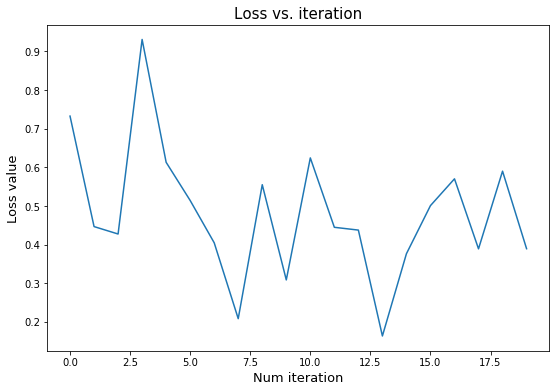

In [99]:
#Not bad!
#But how can we improve the model??
#Add more layers!
#We can add layers and thus more depth, each layer we can filter the IO down to smaller incremets
#By this I mean going from 3072 to 2 more gradually.
#NOTE: USING LOGSOFTMAX AND NLL IS EQUIVALENT TO CROSSENTROPYLOSS



model2 = nn.Sequential(
        nn.Linear(3072, 1024),
        nn.Tanh(),
        nn.Linear(1024, 512),
        nn.Tanh(),
        nn.Linear(512, 128), 
        nn.Tanh(),
        nn.Linear(128, 2),
        nn.LogSoftmax(dim=1))

loss_fn = nn.NLLLoss()

train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)

learning_rate = 1e-4

opitimizer = optim.SGD(model.parameters(), lr = learning_rate)

n_epochs = 20
losses =[]
for epoch in range(n_epochs):
    for img, label in train_loader:
        batch_size = img.shape[0]
        output = model(img.view(batch_size, -1))
        loss = loss_fn(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(float(loss))    
    print("Epochs: %d, Loss: %f" %(epoch, float(loss)))

    
#print("loss", losses)
plt.figure(figsize=(9, 6))
plt.plot(losses)
plt.title("Loss vs. iteration", size=15)
plt.xlabel("Num iteration", size=13)
plt.ylabel("Loss value", size=13)
plt.show()

In [100]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size =64, shuffle = True)

correct = 0
total = 0
with torch.no_grad():
    for img, label in val_loader:
        batch_size = img.shape[0]
        outputs = model2(img.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += label.shape[0]
        correct+= int((predicted == label).sum())
print("Accuracy:", correct/total)

Accuracy: 0.5515


In [101]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [102]:
numel_list = [p.numel() for p in model2.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [103]:
#veryf the shapes of a linear layer computes
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape
#This signifies the limits of fully connected NN
#A fully connected layer is not translation-invariant
#This means that a nn trained on an image in position 2,2 wont be able to recognize the same image at 4,4
#We fix this by adding to the data set random translations of images during training 
#It gives the network a chance to see the image in multiple places
#This model has too many features as seen above which

(torch.Size([1024, 3072]), torch.Size([1024]))

In [104]:
%%HTML
<h3> Building a Convolutional Neural Network </h3>

In [105]:
#Convolutional neural networks allow you to train with in a trainslation invariatnt way
#A convolution is the scalar product of the weiht and martix 
#this scalar product is taken across all portions of the image 
#convolutional nerual networks are great for images

In [106]:
#we'll want to use nn.Conv1d for time series, nn.Con2d for images and nn.conv3d for volumes or videos
conv = nn.Conv2d(3, 16, kernel_size=3)
conv
#Here we have a kernal of size 3x3 and an input sixze 0f 16

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [107]:
#we want a weight of size 3x3x3x16
#The weighte tensor is n_input chanells (3 for RGB), x3x3 (kernel), x n_output channels (16)
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [108]:
#note conv2d expexts BatchxChannelXHightxWeight
#So we need to add a 0th dimension using .unsqueeze()
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape
#The output curiously has 2 missing pixels which is a result of what happens at the boundary of an image 
#Pytorch will skip pixels at the boundaries by default
#the convolution is half the convolution kernal width
#This makes it necessary to pad the image by specifiying padding1=1


(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

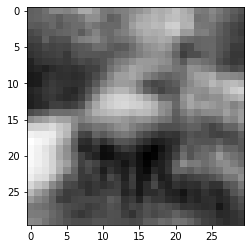

In [109]:
#show the image after being processes 
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

In [110]:
#Pytorch will skip pixels at the boundaries by default
#the convolution is half the convolution kernal width
#This makes it necessary to pad the image by specifiying padding1=1
conv = nn.Conv2d(3,1, kernel_size=3, padding =1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape
#Now the output pixels are preserved

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [111]:
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0/9.0)

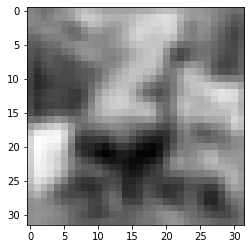

In [112]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [113]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

In [114]:
#Maxpooling is when the output of the convolutional nn and the activation function 
#has the max taken from each quadrent to make a successive output 
#use nn.Maxpool2d
#This allows us to take the most deatures with highest signal frem each layer output
#We use a MaxPool2d(2) to downsize our image by half
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [115]:
#Now we will take our previous fully connected nn and introduce Conv2d and maxpool

model = nn.Sequential(
        nn.Conv2d(3,16, kernel_size=3, padding = 1),
        nn.Tanh(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 8, kernel_size=3, padding = 1), 
        nn.Tanh(),
        nn.MaxPool2d(2),
        #This first linear layer will throw an error for size mismatch of 512x32
        nn.Linear(8*8*8,32),
        nn.Tanh(),
        nn.Linear(32, 2))

In [116]:
#Count number of parameters
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [117]:
#try to run 
model(img.unsqueeze(0))

RuntimeError: size mismatch, m1: [64 x 8], m2: [512 x 32] at C:\w\b\windows\pytorch\aten\src\TH/generic/THTensorMath.cpp:41

In [118]:
#Cannot run due to size missmatch

In [119]:
#Define a class for your model and define a forward propogration fucntion
#The class Net is equivalent to nn.Sequential 
#creating the model in OO fashion allows us to direct the output of self.pool3 
#we can also directly call view() on it to turn it into a BxN vecvot
#we use .view(-1, ...) becuase we don't know how long the batch dimension is
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size =3, padding = 1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16,8, kernel_size=3, padding = 1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [120]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [133]:
#for every nn module we have an nn.functional.module counterpart
#These have all the paramaters as arguments to the fucntion call
#the functional verision of nn.Linear is nn.functional.linear
#this has the signature linear(input, weight,bias = None)
#we are switching to the functional version of poolmax and activation

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1= nn.Conv2d(3,16, kernel_size =3, padding = 1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding =1)
        self.fc1 = nn.Linear(8*8*8,32)
        self.fc2= nn.Linear(32,2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    

In [134]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.1011,  0.1340]], grad_fn=<AddmmBackward>)

In [143]:
def training_loop(n_epochs,optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch ==1 or epoch % 10 ==0:
            print('{} Epoch {}, train {}'.format(datetime.datetime.now(),epoch,float(loss_train)))
            

In [144]:
train_loader =torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle =True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs= 100, 
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn, 
    train_loader = train_loader
)


2020-06-20 15:32:13.357601 Epoch 1, train 92.36895576119423
2020-06-20 15:33:01.132716 Epoch 10, train 54.300046771764755
2020-06-20 15:34:00.812615 Epoch 20, train 47.409017100930214
2020-06-20 15:34:59.671284 Epoch 30, train 43.26512610167265
2020-06-20 15:35:58.889434 Epoch 40, train 39.506379425525665
2020-06-20 15:36:58.136527 Epoch 50, train 36.85192649811506
2020-06-20 15:37:58.202781 Epoch 60, train 34.172077249735594
2020-06-20 15:39:12.639589 Epoch 70, train 32.210994601249695
2020-06-20 15:40:12.679847 Epoch 80, train 30.03835641592741
2020-06-20 15:41:13.335233 Epoch 90, train 27.988755248486996
2020-06-20 15:42:13.086671 Epoch 100, train 25.69972975552082


In [149]:
#Now look at accuracy on training and validation
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 63, shuffle = True)

for loader in [train_loader, val_loader]:
    correct = 0
    total = 0
    
    with torch.no_grad():
        for imgs, labels in loader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    print('Accuracy: %f' % (correct/total))

Accuracy: 0.937100
Accuracy: 0.937100


In [150]:
#This model is way better than the fully connected model with fewer params

In [155]:
#Now we can save the model to a file
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [156]:
#the file contains all parameters of the mode
#all waeights and and biases 
#we can load the model like so 
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [157]:
#The width of a network is the number of neurons per layer or channels per convolution
#Make the network a bit wider by specifying larger number of output channels and increasing the subsquent layers accordingly

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size-3,padding =1)
        self.conv2 = nn.Conv2d(32,16, kernel_size = 3, padding =1 )
        self.fc1 = nn.Linear(8*8*16, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_piil2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1,8*8*16)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [158]:
#You cna pass a variable to init to parametrize the width

class Net(nn.Module):
    def __init__(self, n_chans1=32):
        super(Net, self).__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = Net(n_chans1=32)


In [159]:
sum(p.numel() for p in model.parameters())

38386

In [160]:
#Implement regularization to prevent overfitting 
#penalizes model for overfitting
# L1 and L2 regulatization
#L2 regularizatoin also called weight decay as it reduces the weights during optimization
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs,labels)
            
            l2_lambda = 0.9
            l2_norm = sum(p.pow(2.0).sum() for p in model.perameters())
            loss = loss + l2_lambda * l2_norm
            
            optmizer.zero_grad()
            loss.backwards()
            optimizer.step()
            
            loss_train += loss.item()
            
        

In [ ]:
#We can also use Dropout startegy to comabt overfitting
#here some of the neurons are disabled randomly at each training iteration
#use nn.Dropput nn.Dropout2d and nn.Dropout3d and place them in betwen non linear activation functions
#The input is the probability of dropout
class Net(nn.Module):
    def __init__(self, n_chans1=32):
        super(Net, self).__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2D(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2D(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [1]:
#Batch Normalization
#nn.BatchNorm1D , 2D, 3D
class Net(nn.Module):
    def __init__(self, n_chans1=32):
        super(Net, self).__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2D(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2D(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


NameError: name 'nn' is not defined

In [ ]:
#The Depth of a network  allows a mdoel to deal with hierarchical informaiton where we need 
#to inderstan context in order to say something about the input
#Increasing depth means increasing length of sequence of operation a network will perform when processing input
#Adding depth generally makes things harder to converge 

class Net(nn.Module):
    def __init__(self, n_chans1=32):
        super(Net, self).__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out + out1)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
#building ver deep models
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x